# Sample Project - Predicting Chance of Rain Tomorrow

# Introduction

Data obtained from: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

Based on how the dataset looks, I want to predict the likelihood of RainTomorrow given some vector of regressor variables (which will be determined later). 

This will consist of 2 parts.

#### 1. I will use a LASSO regression to estimate the values of the $\beta$ coefficient vector.


In a LASSO regression, we simply minimize the loss function subject to a constraint that the sum of the absolute values of the coefficients must be less than some upper bound.

For example, in an OLS regression, the LASSO optimization problem would be:

$ min ||Y-\beta '\chi||^2 $ subject to $ \sum_{i=1}^{n}| \beta_i | < t $


However, an OLS regression on a binary dependent variable isn't sensible because the linear fit will be flawed at extreme values of X and will likely predict probabilities greater than 1 or less than 0. 

#### 2. So in step 2, I will use a logit regression to estimate the values of the $\beta$ coefficient vector, using the vector of regressor variables chosen by LASSO

$ log[p/(1-p)] = \alpha + \beta '\chi + \epsilon $

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; where p is the probability that RainTomorrow=1, and the vector of regressor 
variables X are the variables chosen earlier by LASSO

## Importing Data

In [3]:
#installing some common packages
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [4]:
#importing csv file
df1 = pd.read_csv('weatherAUS.csv')

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
Date             145460 non-null object
Location         145460 non-null object
MinTemp          143975 non-null float64
MaxTemp          144199 non-null float64
Rainfall         142199 non-null float64
Evaporation      82670 non-null float64
Sunshine         75625 non-null float64
WindGustDir      135134 non-null object
WindGustSpeed    135197 non-null float64
WindDir9am       134894 non-null object
WindDir3pm       141232 non-null object
WindSpeed9am     143693 non-null float64
WindSpeed3pm     142398 non-null float64
Humidity9am      142806 non-null float64
Humidity3pm      140953 non-null float64
Pressure9am      130395 non-null float64
Pressure3pm      130432 non-null float64
Cloud9am         89572 non-null float64
Cloud3pm         86102 non-null float64
Temp9am          143693 non-null float64
Temp3pm          141851 non-null float64
RainToday        142199 non-null obje

## Cleaning data

In [6]:
df1.sample(10)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
60850,2016-07-29,Bendigo,8.0,11.2,0.4,NaN,NaN,NNW,37.0,NW,...,90.0,95.0,1024.3,1021.9,7.0,8.0,8.8,10.5,No,Yes
26985,2016-12-26,Penrith,18.8,34.9,0.0,NaN,NaN,NW,33.0,E,...,68.0,35.0,NaN,NaN,NaN,NaN,24.6,33.9,No,No
28444,2012-07-31,Richmond,1.1,15.6,0.0,2.8,NaN,SSW,41.0,SW,...,58.0,44.0,1026.6,1023.4,NaN,NaN,11.7,15.1,No,No
124614,2011-03-03,SalmonGums,13.0,28.0,0.0,NaN,NaN,ESE,50.0,ENE,...,49.0,28.0,NaN,NaN,NaN,NaN,20.6,27.1,No,No
89041,2014-03-15,Cairns,21.3,30.2,0.0,4.4,11.3,E,35.0,S,...,66.0,55.0,1013.7,1010.7,1.0,1.0,26.5,29.3,No,No
93405,2009-04-05,Townsville,22.3,32.2,0.0,7.4,10.1,NE,37.0,ESE,...,69.0,62.0,1012.0,1009.0,3.0,3.0,28.9,30.6,No,No
127343,2010-05-27,Walpole,10.9,17.3,12.8,NaN,NaN,SW,56.0,WNW,...,97.0,89.0,1004.1,1007.4,NaN,NaN,12.1,14.0,Yes,Yes
26519,2015-09-17,Penrith,10.6,21.8,0.0,NaN,NaN,SE,39.0,SE,...,56.0,52.0,NaN,NaN,NaN,NaN,16.5,18.6,No,No
103138,2010-08-09,Nuriootpa,5.8,9.9,5.6,0.4,0.0,ENE,39.0,N,...,82.0,76.0,1014.7,1013.1,8.0,8.0,7.6,9.7,Yes,No
112125,2010-05-30,Witchcliffe,10.9,18.5,3.4,NaN,NaN,N,20.0,N,...,74.0,71.0,1019.8,1018.0,NaN,NaN,15.1,18.1,Yes,Yes


In [188]:
df1['Date'].min()

'2007-11-01'

In [189]:
df1['Date'].max()

'2017-06-25'

<AxesSubplot:>

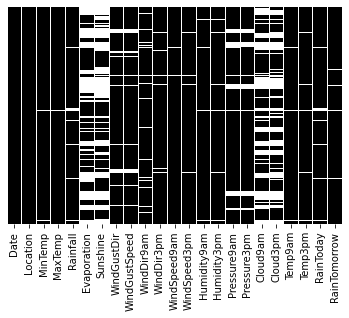

In [7]:
#Looks like there's a lot of nulls in certain columns
sns.heatmap(df1.isnull(),yticklabels=False,cbar=False,cmap='bone')

In [8]:
#The nulls seems to just be equivalent to 0. So let's fill in nulls with 0

df1.fillna(0, inplace=True)
df1.sample(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
21016,2017-03-15,NorahHead,19.8,25.9,32.0,0.0,0.0,ENE,48.0,E,...,100.0,81.0,1019.9,1018.1,0.0,0.0,21.7,25.6,Yes,Yes
50558,2013-05-14,Tuggeranong,-0.2,13.5,6.4,0.0,0.0,WNW,37.0,WSW,...,95.0,48.0,1014.8,1012.5,0.0,0.0,5.3,11.6,Yes,No
6345,2009-10-24,Cobar,17.3,31.3,0.0,0.0,7.0,SSW,37.0,E,...,21.0,18.0,1020.0,1017.7,7.0,7.0,21.8,28.5,No,No
88354,2012-02-28,Cairns,23.6,31.0,21.0,3.2,2.6,SSE,37.0,S,...,80.0,74.0,1008.1,1006.4,6.0,7.0,27.9,28.3,Yes,Yes
9617,2010-07-14,CoffsHarbour,16.4,21.7,0.0,2.2,5.8,NNW,59.0,NE,...,69.0,40.0,1011.8,1011.3,6.0,1.0,18.5,19.9,No,No


In [9]:
#"RainToday" and "RainTomorrow" are recorded with yes/no. Let's turn that into 1/0
df1['RainToday']=df1['RainToday'].apply(lambda x: 1 if x=='Yes' else 0)
df1['RainTomorrow']=df1['RainTomorrow'].apply(lambda x: 1 if x=='Yes' else 0)

In [10]:
df1.sample(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
102160,2016-05-29,MountGambier,7.9,11.5,0.0,0.0,0.0,NE,30.0,N,...,73.0,64.0,1021.3,1020.5,8.0,2.0,9.4,9.5,0,0
68865,2013-04-20,Melbourne,9.8,19.0,0.0,4.0,9.4,SSE,44.0,SE,...,68.0,44.0,1023.3,1019.0,0.0,0.0,12.2,18.2,0,0
132193,2015-03-11,Hobart,11.3,22.6,0.2,4.8,7.2,NW,56.0,NNW,...,57.0,36.0,1011.2,1008.6,7.0,7.0,14.0,20.8,0,0
102120,2016-04-19,MountGambier,6.4,25.9,0.0,2.4,8.1,NW,37.0,NNE,...,57.0,26.0,1017.5,1016.1,6.0,1.0,14.4,25.4,0,0
7224,2012-04-20,Cobar,13.5,27.7,0.0,3.4,0.0,WSW,31.0,W,...,43.0,29.0,1017.1,1013.6,1.0,2.0,22.6,27.0,0,0


In [117]:
df1.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

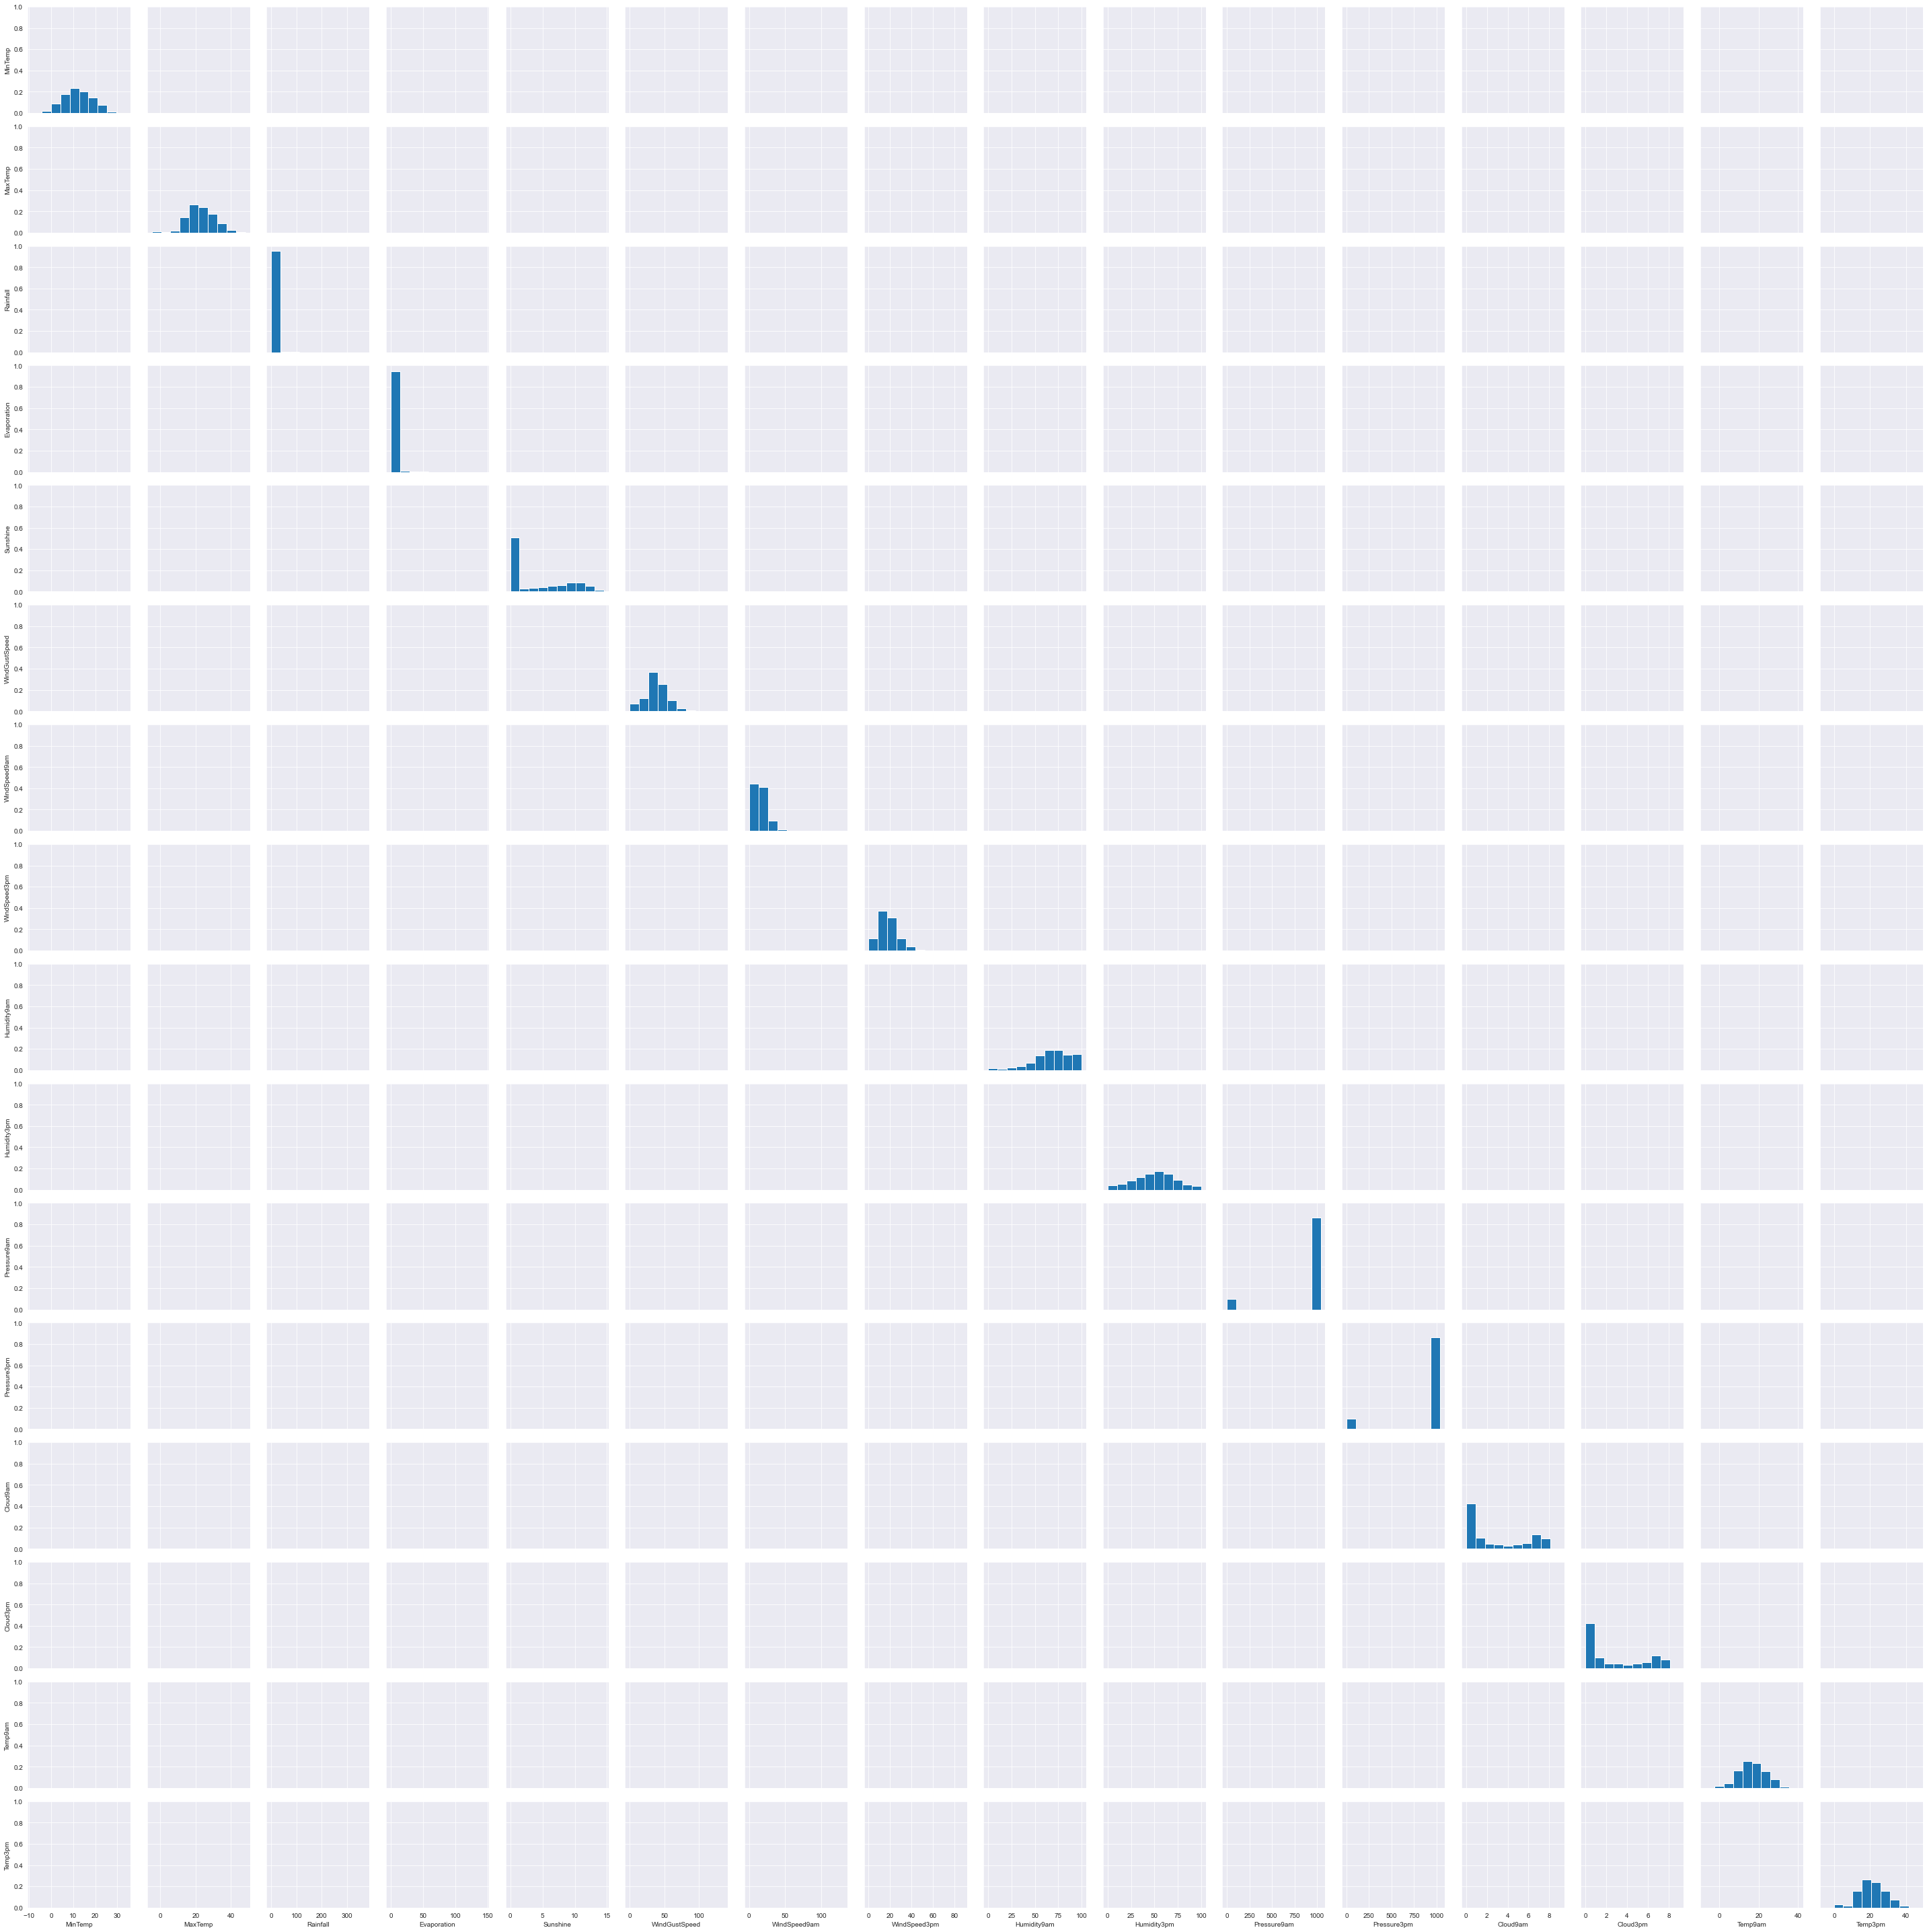

In [194]:
#let's do a quick sanity check to see if filling in nulls with 0 makes sense.
#We can plot the distribution of all variables to see if they're distributed smoothly

df2=df1[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed','WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm']]


grid = sns.PairGrid(df2)
grid.map_diag(plt.hist)

#if there were null values that were supposed to be positive and I filled them in as 0,
#then I would expect a bimodal distribution at 0 and some some other value, which is mostly not seen here,
#except for Cloud9am and Cloud3pm

<AxesSubplot:xlabel='Cloud9am'>

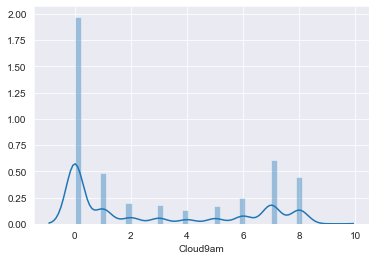

In [343]:
# To focus my time and avoid deep-diving into endless problems, I won't investigate this null issue further and continue with my exercise
sns.distplot(df1['Cloud9am'])

In [196]:
#for completeness, I should also reclassify the wind direction columns into categorical columns
df1['WindGustDir'].value_counts()
df1['WindDir9am'].value_counts()
df1['WindDir3pm'].value_counts()

SE     10838
W      10110
S       9926
WSW     9518
SSE     9399
SW      9354
N       8890
WNW     8874
NW      8610
ESE     8505
E       8472
NE      8263
SSW     8156
NNW     7870
ENE     7857
NNE     6590
0       4228
Name: WindDir3pm, dtype: int64

In [11]:
#since the data records multiple directions, I will reclassify them into either N, E, S, or W
#To do the reclassification, I will first make a function that takes in an input and outputs a direction

def direction(x):
    """
    Output: Returns the direction of the wind, either N, W, S, or E.
    
    Parameters
    ----------
    x: str
        A word (up to 3 letters) that indicates a direction, e.g. NNW
    
    Returns
    -------
    str
        A single primary direction
        
    Logic
    -----
    -if the entry only contains a single letter, then it is from that direction.
    -if the entry contains 3 letters, it will be reclassified to the direction of the most common letter: e.g. NNW -> N
    -if the entry contains 2 letters, I will randomize with 50/50 chance which of the 2 directions it's assigned to.
    """    
    if x==0: #As a first pass: I filled in nulls as 0s. Just as a quick cheat I will randomize these nulls into a direction
        return random.choice('NESW')
    else:
        x=x.upper() #make sure input is uppercase before applying any further transformations
    
        ###Error handling###
        for i in x:
            if i not in 'NESW': #raise an error if entry is not a valid direction
                raise Exception('Input is not a direction')
        if len(x)>3: #raise an error if entry is more than 3 letters long
            raise Exception('Input is longer than 3 letters')
        ##---------------##    

        if len(x)==3: #classify direction as the most common letter in the input
            return pd.Series([i for i in x]).value_counts().idxmax()

        if len(x)==2: #randomize which of the 2 letters is the direction
            return random.choice(x)

        else: #for a single letter, assign that letter as the direction
            return x
    

In [12]:
#now I will reclassify the direction columns into NESW directions

df1['WindGustDir'] = df1['WindGustDir'].apply(lambda x: direction(x))
df1['WindDir9am'] = df1['WindDir9am'].apply(lambda x: direction(x))
df1['WindDir3pm'] = df1['WindDir3pm'].apply(lambda x: direction(x))
df1[['WindDir3pm']].sample(5)

#(in retrospect I should have wrote the function to operate on a dataframe, not an entry, for quicker computation)

,WindDir3pm
120695,E
64470,S
134085,W
54357,E
1977,N


In [199]:
# data looks clean now
df1.sample(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
29066,2014-06-12,Richmond,6.2,19.7,0.2,0.0,0.0,N,0.0,S,N,0.0,17.0,100.0,53.0,1022.2,1018.5,0.0,0.0,9.4,19.1,0,0
53303,2012-05-25,MountGinini,-2.6,0.0,20.8,0.0,0.0,E,0.0,W,N,28.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
44136,2013-07-06,Wollongong,9.4,16.8,0.0,0.0,0.0,W,48.0,W,W,17.0,24.0,42.0,32.0,1018.0,1017.8,0.0,0.0,12.3,15.9,0,0
142217,2017-03-31,Darwin,23.0,31.4,9.4,6.8,3.8,N,59.0,E,W,9.0,13.0,89.0,69.0,1011.0,1007.0,7.0,7.0,25.8,30.9,1,1
86540,2015-09-05,Brisbane,12.0,23.6,0.0,6.8,9.3,E,22.0,S,E,6.0,11.0,61.0,53.0,1022.7,1018.8,1.0,3.0,19.4,21.3,0,0


Tet's reclassify the categorical columns into dummy columns. N will be the reference direction. 
The logic is as follows:

|Direction|East|West|South|
|---------|--------|--------|---------|
|North|0|0|0|
|East|1|0|0|
|West|0|1|0|
|South|0|0|1|

In [13]:
df1['WindGustDir_E']=df1['WindGustDir'].apply(lambda x: 1 if x=='E' else 0)
df1['WindGustDir_W']=df1['WindGustDir'].apply(lambda x: 1 if x=='W' else 0)
df1['WindGustDir_S']=df1['WindGustDir'].apply(lambda x: 1 if x=='S' else 0)

df1['WindDir9am_E']=df1['WindDir9am'].apply(lambda x: 1 if x=='E' else 0)
df1['WindDir9am_W']=df1['WindDir9am'].apply(lambda x: 1 if x=='W' else 0)
df1['WindDir9am_S']=df1['WindDir9am'].apply(lambda x: 1 if x=='S' else 0)

df1['WindDir3pm_E']=df1['WindDir3pm'].apply(lambda x: 1 if x=='E' else 0)
df1['WindDir3pm_W']=df1['WindDir3pm'].apply(lambda x: 1 if x=='W' else 0)
df1['WindDir3pm_S']=df1['WindDir3pm'].apply(lambda x: 1 if x=='S' else 0)


In [201]:
#data now looks clean
pd.set_option('display.max_columns', None)
df1.sample(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,WindGustDir_E,WindGustDir_W,WindGustDir_S,WindDir9am_E,WindDir9am_W,WindDir9am_S,WindDir3pm_E,WindDir3pm_W,WindDir3pm_S
12236,2009-06-19,Moree,5.7,21.7,0.0,3.2,7.2,E,39.0,E,E,9.0,19.0,73.0,39.0,1024.6,1020.7,1.0,6.0,11.3,20.1,0,0,1,0,0,1,0,0,1,0,0
125165,2012-10-04,SalmonGums,5.3,23.2,0.0,0.0,0.0,W,39.0,N,W,11.0,17.0,62.0,32.0,0.0,0.0,0.0,0.0,15.9,21.9,0,0,0,1,0,0,0,0,0,1,0
81228,2009-08-19,Dartmoor,10.0,20.3,0.0,1.6,7.6,N,48.0,N,N,22.0,26.0,61.0,51.0,1018.7,1014.5,0.0,0.0,12.7,19.9,0,0,0,0,0,0,0,0,0,0,0
89959,2016-09-18,Cairns,20.3,29.5,0.0,0.0,0.0,E,30.0,S,E,17.0,20.0,69.0,67.0,1015.9,1012.0,0.0,1.0,25.8,28.6,0,0,1,0,0,0,0,1,1,0,0
75354,2010-01-10,Portland,14.8,29.2,0.0,8.8,13.4,E,37.0,E,E,22.0,13.0,77.0,45.0,1016.6,1014.4,0.0,2.0,18.6,28.5,0,0,1,0,0,1,0,0,1,0,0


After a bit of Googling, I just realized that there's a function, pd.get_dummies(), that can automatically convert columns into dummy columns. Ooops, today I learned.

In [202]:
#create a new dataframe with the columns I want
df1.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'WindGustDir_E',
       'WindGustDir_W', 'WindGustDir_S', 'WindDir9am_E', 'WindDir9am_W',
       'WindDir9am_S', 'WindDir3pm_E', 'WindDir3pm_W', 'WindDir3pm_S'],
      dtype='object')

In [15]:
data = df1[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'WindGustDir_E',
       'WindGustDir_W', 'WindGustDir_S', 'WindDir9am_E', 'WindDir9am_W',
       'WindDir9am_S', 'WindDir3pm_E', 'WindDir3pm_W', 'WindDir3pm_S','RainTomorrow']]

data.sample(5)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindGustDir_E,WindGustDir_W,WindGustDir_S,WindDir9am_E,WindDir9am_W,WindDir9am_S,WindDir3pm_E,WindDir3pm_W,WindDir3pm_S,RainTomorrow
78307,13.4,29.3,0.0,9.8,12.0,26.0,9.0,15.0,66.0,38.0,...,0,0,1,0,0,1,0,1,0,0
86020,19.1,29.5,0.0,6.2,10.8,24.0,4.0,11.0,64.0,53.0,...,1,0,0,0,0,1,1,0,0,0
123307,13.9,26.3,0.4,5.2,5.5,41.0,17.0,15.0,66.0,42.0,...,0,0,0,0,0,0,0,0,1,0
68624,7.1,16.5,0.0,1.4,7.3,46.0,20.0,26.0,67.0,55.0,...,0,1,0,0,0,0,0,1,0,1
105984,20.1,33.6,12.6,12.6,6.5,72.0,22.0,19.0,75.0,30.0,...,1,0,0,0,0,0,1,0,0,0


## Exploratory analysis

<AxesSubplot:>

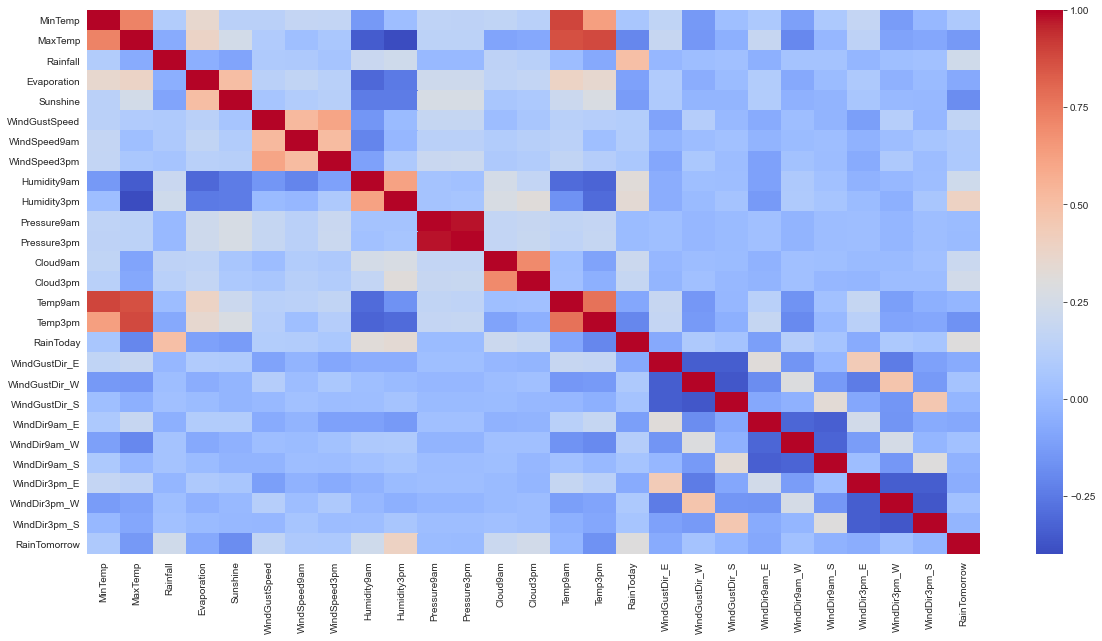

In [18]:
# getting a quick understanding of my dataset
plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
sns.heatmap(data.corr(),cmap='coolwarm',annot=False)

In [23]:
data.corr().loc['RainTomorrow'].abs().sort_values(ascending=False)

RainTomorrow     1.000000
Humidity3pm      0.397951
RainToday        0.305744
Cloud3pm         0.239515
Rainfall         0.233877
Humidity9am      0.228508
Cloud9am         0.204218
Sunshine         0.180791
Temp3pm          0.166182
WindGustSpeed    0.165981
MaxTemp          0.138551
WindSpeed9am     0.086609
MinTemp          0.085393
WindSpeed3pm     0.080084
WindDir9am_E     0.078762
Evaporation      0.072676
WindGustDir_E    0.067643
WindDir3pm_E     0.056992
WindGustDir_W    0.047353
WindDir9am_S     0.037598
WindDir9am_W     0.036509
WindDir3pm_W     0.035105
WindDir3pm_S     0.024954
Temp9am          0.020799
WindGustDir_S    0.019731
Pressure9am      0.005810
Pressure3pm      0.005274
Name: RainTomorrow, dtype: float64

RainTomorrow looks to be most related with Humidity3pm, RainToday, Cloud3pm, Rainfall, and Sunshine.

However, for a more rigourous feature selection approach, let's use LASSO to select the regressor variables


# Part 1. LASSO Regression

In [225]:
#install regression packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [227]:
#setting up regressor and outcome variable dataframes
X_complete = data[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustSpeed',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'WindGustDir_E',
       'WindGustDir_W', 'WindGustDir_S', 'WindDir9am_E', 'WindDir9am_W',
       'WindDir9am_S', 'WindDir3pm_E', 'WindDir3pm_W', 'WindDir3pm_S']]
              
X_complete = sm.add_constant(X_complete) #adding a constant to regressors
              
y=data[['RainTomorrow']]
X_complete.head(5)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,const,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,WindGustDir_E,WindGustDir_W,WindGustDir_S,WindDir9am_E,WindDir9am_W,WindDir9am_S,WindDir3pm_E,WindDir3pm_W,WindDir3pm_S
0,1.0,13.4,22.9,0.6,0.0,0.0,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0,1,0,0,1,0,0,1,0
1,1.0,7.4,25.1,0.0,0.0,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,0.0,0.0,17.2,24.3,0,0,1,0,0,0,0,0,1,0
2,1.0,12.9,25.7,0.0,0.0,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,0.0,2.0,21.0,23.2,0,0,1,0,0,1,0,0,1,0
3,1.0,9.2,28.0,0.0,0.0,0.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,0.0,18.1,26.5,0,1,0,0,0,0,1,1,0,0
4,1.0,17.5,32.3,1.0,0.0,0.0,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,1,0,1,0,0,0,1,0


In [270]:
lassoReg = Lasso(alpha=0.00007, normalize=True)

In [271]:
lassoReg.fit(X_complete,y)

Lasso(alpha=7e-05, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

<AxesSubplot:title={'center':'Model Coefficients'}>

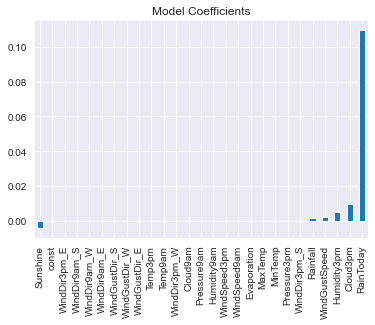

In [272]:
#Let's check magnitude of the coefficients

regressors = X_complete.columns
coef = pd.Series(lassoReg.coef_,regressors).sort_values()

coef.plot(kind='bar', title='Model Coefficients')

In [281]:
#results of feature selection
LASSOresults = pd.DataFrame(pd.Series(lassoReg.coef_,regressors).sort_values(),columns=['Coefficient'])
LASSOresults[LASSOresults['Coefficient']!=0].sort_values(by=['Coefficient'],ascending=False)

,Coefficient
RainToday,0.109591
Cloud3pm,0.009316
Humidity3pm,0.004717
WindGustSpeed,0.002076
Rainfall,0.001777
Sunshine,-0.004107


# Part 2. Logit Regression

In [309]:
#import regression package
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [310]:
#split data into regressor and outcome variables
X = data[['RainToday','Cloud3pm','Humidity3pm','WindGustSpeed','Rainfall','Sunshine']]
X = sm.add_constant(X) #adding a constant to regressors

X.head()
#y.head()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,const,RainToday,Cloud3pm,Humidity3pm,WindGustSpeed,Rainfall,Sunshine
0,1.0,0,0.0,22.0,44.0,0.6,0.0
1,1.0,0,0.0,25.0,44.0,0.0,0.0
2,1.0,0,2.0,30.0,46.0,0.0,0.0
3,1.0,0,0.0,16.0,24.0,0.0,0.0
4,1.0,0,8.0,33.0,41.0,1.0,0.0


In [311]:
#split data into training and testing sets so that I can see how well my model works afterwards
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) #using 70% of the data to train regression

In [312]:
regression = sm.Logit(endog=y_train, exog=X_train, missing='raise').fit()

Optimization terminated successfully.
         Current function value: 0.402264
         Iterations 7


In [313]:
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           RainTomorrow   No. Observations:               101822
Model:                          Logit   Df Residuals:                   101815
Method:                           MLE   Df Model:                            6
Date:                Tue, 22 Dec 2020   Pseudo R-squ.:                  0.2375
Time:                        16:02:38   Log-Likelihood:                -40959.
converged:                       True   LL-Null:                       -53718.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -4.8853      0.041   -118.903      0.000      -4.966      -4.805
RainToday         0.6166      0.023     27.389      0.000       0.572       0.661
Cloud3pm          0.1062      0.003     38.027      0.000       0.101       0.112
Humidity3pm       0.0405      0.001     78.163      0.000       0.039       0.041
WindGustSpeed     0.0269      0.001     49.618      0.000       0.026       0.028
Rainfall          0.0169      0.001     13.274      0.000       0.014       0.019
Sunshine         -0.0745      0.002    -31.379      0.000      -0.079      -0.070
=================================================================================
"""

In [314]:
#generate predictions based on the remaining test data
predictions = regression.predict(X_test) 
predictions.head(5)

26191    0.207659
25452    0.239582
96666    0.153791
56739    0.870548
88977    0.268538
dtype: float64

In [315]:
#let's compare predictions vs actual
predictions_actual = pd.DataFrame(predictions,columns=['ChanceofRainTomorrow'])
predictions_actual['RainTomorrow']=y_test['RainTomorrow']
predictions_actual['Residual']=y_test['RainTomorrow']-predictions_actual['ChanceofRainTomorrow']
predictions_actual.head(10)

,ChanceofRainTomorrow,RainTomorrow,Residual
26191,0.207659,0,-0.207659
25452,0.239582,0,-0.239582
96666,0.153791,1,0.846209
56739,0.870548,1,0.129452
88977,0.268538,1,0.731462
55269,0.626643,0,-0.626643
73521,0.091443,0,-0.091443
11210,0.796480,1,0.203520
94502,0.055873,0,-0.055873
144644,0.170367,0,-0.170367


<AxesSubplot:xlabel='Residual'>

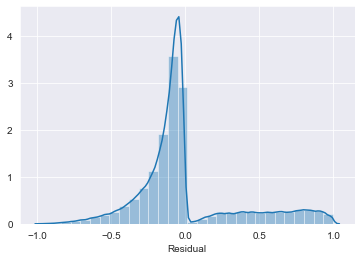

In [316]:
#check that errors look normally distributed
sns.distplot(predictions_actual['Residual'],bins=30)

Errors are definitely not normally distributed, as there's a positive skew to the residuals and a sharp cutoff after 0. 

<function matplotlib.pyplot.show(close=None, block=None)>

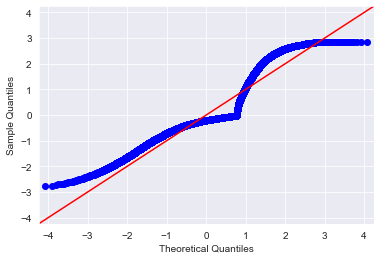

In [334]:
#generating a normal Q-Q plot
sm.qqplot(predictions_actual['Residual'], line = "45", fit = True)
pylab.show

If this set of residuals is normally distributed, we would expect the plot of the residuals to approximately follow a straight line.
At the extreme right, our actual residuals are not as large as would be expected under normality.
At the extreme left, our actual residuals are again not as small as would be expected under normality.
There's also a sharp kink in the middle of the distribution where actual values are not as large as expected.

I think one guess for the cause could be because I overfit the regression by including both Rainfall and RainToday as regressors? When RainToday is just a binary variable which is highly correlated with Rainfall, this could somehow cause the sharp drop in the residual distribution plot.